<a href="https://colab.research.google.com/github/rohankrgupta/Orca-call-Classifier-Machine-learning/blob/main/OrcaNet_Main_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have a total of 240 Spectrograms representing 10 second Audio of Orca Calls/No Calls <br>
Due to data scarcity, we cant use CNNs efficiently. Thus we first extract the features using OpenCV library and then train a Random Decision Forest on top to outperform CNN benchmark achieving overall 88% accuracy.<br><br>
Total Orca Call positive Spectrograms : 120
Total Orca Call negative Spectrograms : 120 

In [1]:
#dependencies

%matplotlib inline

import matplotlib
import os
import random
import pandas as pd
import imageio
import cv2
import shutil
from scipy.stats.mstats import linregress
from tensorflow.keras.preprocessing.image import img_to_array
from random import uniform
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

matplotlib.use('Agg')

Importing the Pre-processed Mel-Spectrograms in order to perform the call classification

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Spectrograms.zip to Spectrograms.zip
User uploaded file "Spectrograms.zip" with length 217168372 bytes


In [25]:
import os
import zipfile

local_zip = '/content/Spectrograms.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

base_dir = '/content/Spectrograms'

Sample Mel-Spectrogram for a Positive Orca Call 

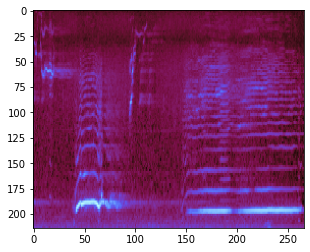

In [4]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/Spectrograms/train/call/spect-123.png')
plt.imshow(image)

Model Class - OrcaNet <br>
Consists of : <br>
1) Feature Extractor<br>
2) Random Descision Forest Classifier

In [39]:
class OrcaNet:
  @staticmethod
  def extract_features(image_path, vector_size=32):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc
  def classifier(n_estimators=100,random_state=42):
    rf = RandomForestClassifier(n_estimators=100,random_state=42)
    return rf



Extracting the features from Spectrograms and converting to Matrix 


In [12]:
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
          filename = os.path.join(root, basename)
          yield filename

In [37]:
positive = [] #empty list
negative = [] #empty list

num_calls = 0
num_no_calls = 0

train_dir = "/content/Spectrograms/test/"
class_names = ['call', 'no_call']

for c in class_names:
  images = [x for x in os.listdir(os.path.join(train_dir, c)) if x.lower().endswith('png')]
  for image in images:
    img = cv2.imread(train_dir + c + image)
    img_path = os.path.join(train_dir + c + '/' + image)
    feat_vector = OrcaNet.extract_features(img_path, 64)
    if c == 'call':
      positive.append(feat_vector)
      num_calls = num_calls + 1
    else:
      negative.append(feat_vector)
      num_no_calls = num_no_calls + 1 


x = np.concatenate((positive, negative), axis = 0)

z = np.zeros(num_calls)
o = np.ones(num_no_calls)
y = np.concatenate((z,o), axis=0).reshape(x.shape[0], 1) 

print("x shape", x.shape)
print("y shape", y.shape)


x shape (241, 4096)
y shape (241, 1)


Preparing Training and Test Sets

In [43]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.10,random_state=42)
x_train = x_train.T
y_train = y_train.T
x_test  = x_test.T
y_test  = y_test.T


Creating the Model & Training Phase. <br>
Model Achieves an 88% Accuracy on Test Set

In [46]:
model = OrcaNet.classifier()
model.fit(x_train.T,y_train.T)
print("Random Forest Classification Test Score:",model.score(x_test.T,y_test.T))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Classification Test Score: 0.88


Analysing the Model Performance through Confusion Matrix : 

(4096, 25)


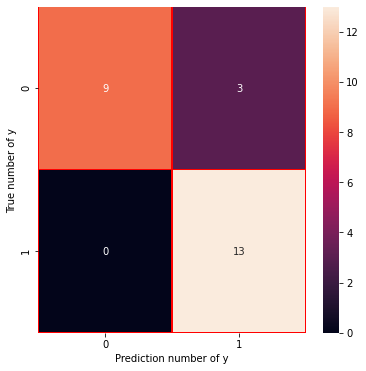

In [48]:
import seaborn as sns
print(x_test.shape)

y_prediction = model.predict(x_test.T)
y_true = y_test.T

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_prediction)

f, ax= plt.subplots(figsize=(6,6))
sns.heatmap(cm,annot= True,linewidths=0.4,linecolor="red",fmt= ".0f",ax=ax)
plt.xlabel("Prediction number of y")
plt.ylabel("True number of y")
plt.show()

Confusion Matrix Analysis 
<br>
True Positive : 13
<br>
False Positive : 0
<br>
True Negative : 9
<br>
False Negative : 3 